In [4]:
import sys
import os
import pandas as pd

path = os.path.abspath('../..')
if path not in sys.path:
    sys.path.insert(0, path)
    
sys.path

from primer3plus.utils import reverse_complement as rc
import primer3
from aqbt.contrib.uwbf import primer_utils
from aqbt import AquariumBuildTools
aqtools = AquariumBuildTools.from_toml('creds.secret.toml')
aqtools.sessions

aq = aqtools.sessions['production']['aquarium']

# Evaluate Homologies

Evaluate sequences and homologies for all fragments. Evaluate appropriate melting temperatues.

# Evaluate Gels

In [15]:
item = aq.Item.find(512001)

fvs = aq.FieldValue.where({'role': 'output', 'child_item_id': item.id})
op = fvs[0].operation

for fv in op.inputs:
    print(fv.item)

<Item id=511997 rid=36>


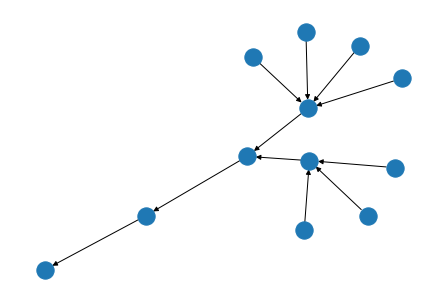

In [48]:
import networkx as nx


def get_predecessors_ops(item):
    fvs = aq.FieldValue.where({'role': 'output', 'child_item_id': item.id})
    for fv in fvs:
        yield fv.operation
        
def get_predecessor_items(op):
    for fv in op.inputs:
        if fv.item:
            yield fv.item

class SampleGraph(object):
    
    def __init__(self):
        self.g = nx.DiGraph()
        
    def to_hash(self, x):
        return (x.__class__.__name__, x.id)
        
    def add_node(self, x):
        k = self.to_hash(x)
        data = x.dump()
        self.g.add_node(k, data=data)
        return k, data
    
    def add_edge(self, m1, m2, **kwargs):
        n1, _ = self.add_node(m1)
        n2, _ = self.add_node(m2)
        self.g.add_edge(n1, n2, **kwargs)

g = SampleGraph()

items = [aq.Item.find(512001)]
depth = 0
while items and depth < 4:
    depth += 1
    visited = []
    for i2 in items:
        ops = get_predecessors_ops(i2)
        for op in ops:
            for i1 in get_predecessor_items(op):
                g.add_edge(i1, i2)
                visited.append(i1)
    items = visited

nx.draw(g.g)

In [27]:
item[0].object_type.name

'Gel Slice'